# Squeezing in atomic qudits

In this notebook we will look into experiments with atomic qudits and reproduce them with Qiskit. We first want to look at what we are trying to reproduce with Qiskit. The graph below is from a [paper](https://arxiv.org/abs/1507.03782) by Helmut Strobel. In this paper the collective spin of a Bose-Einstein-Condensate is used to observe nonlinearity in spin squeezing.

In [1]:
import numpy as np
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

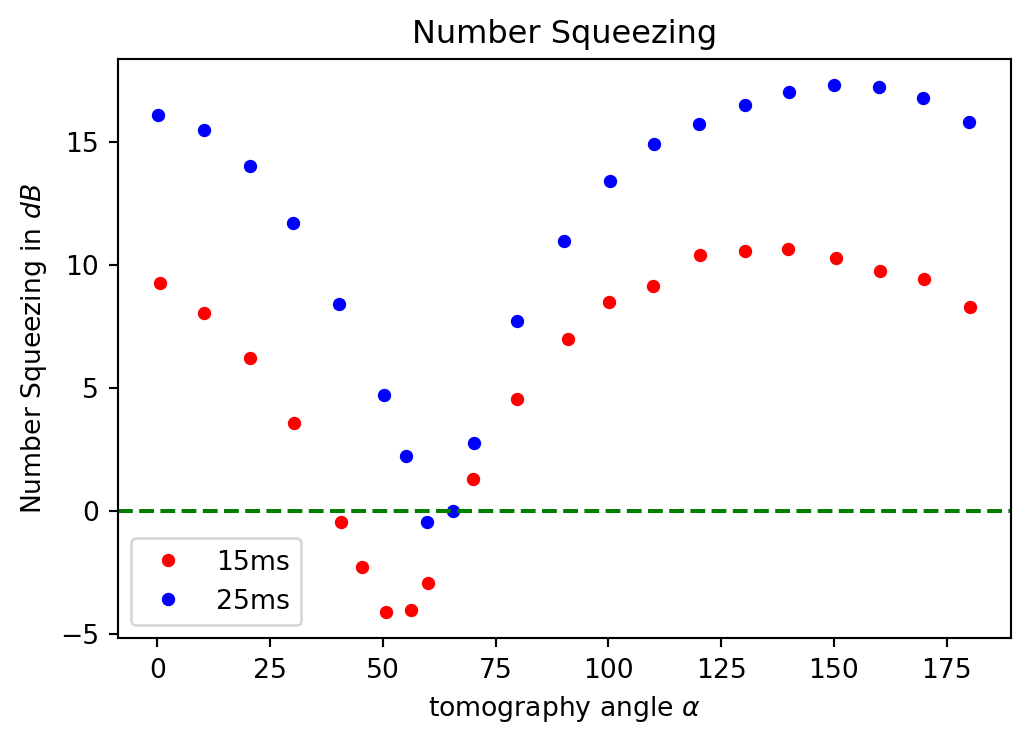

In [2]:
data_strobel_15 = pd.read_csv("Data/Strobel_Data_15ms.csv", names=["dB", "alpha"])
data_strobel_25 = pd.read_csv("Data/Strobel_Data_25ms.csv", names=["dB", "alpha"])

plt.figure(dpi=96)
plt.title("Number Squeezing")
plt.plot(data_strobel_15.dB, data_strobel_15.alpha, "ro", label="15ms", markersize=4)
plt.plot(data_strobel_25.dB, data_strobel_25.alpha, "bo", label="25ms", markersize=4)
plt.axhline(y=0, color="g", linestyle="--")
plt.ylabel(r"Number Squeezing in $dB$")
plt.xlabel(r"tomography angle $\alpha$")
_ = plt.legend()

This number squeezing is achieved by performing the following Bloch-sphere rotations. 

We prepare the collective spin such that the Bloch-sphere-vector points to one of the poles. 


1. __First step__.  As a first step the vector is rotated onto the equator.

![first step](aux_files/1.png)


2. __Second step__ . Then the state is being squeezed, such that it starts to wrap around the Bloch-sphere.

![second step](aux_files/2.png)


3. __Third step__ . In the last step we rotate the state around the $X$-axis. This rotation corresponds to the angle $\alpha$ in this notebook.


![third step](aux_files/alpha.png)

We will now simulate the sequence in Qiskit.

import the credentials to access the server and import the device. Make sure that you followed the necessary steps for obtaining the credentials as desribed in the [introduction](https://github.com/Qiskit-Extensions/qiskit-cold-atom/blob/main/docs/tutorials/05_cold_atom_provider.ipynb).

In [3]:
from qiskit_cold_atom.providers import ColdAtomProvider

# enable an account
provider = ColdAtomProvider.enable_account(url = ["http://qsimsim.synqs.org/singlequdit", "http://qsimsim.synqs.org/fermions"], username="synqs_test",token="Cm2TXfRmXennMQ5")

In [4]:
spin_device_backend = provider.get_backend("synqs_single_qudit_simulator")

This created a single qudit device, which has the following operations.

we now define the quantum circuit that implements the experimental sequence

In [5]:
Nat = 200
l = Nat / 2  # spin length
omegax = 2 * np.pi * 20
t1 = 15e-3
t2 = 25e-3
Lambda = 1.5

chi = Lambda * abs(omegax) / Nat

Ntrott = 15;
alphas = np.linspace(0, np.pi, 15)

In [6]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit_synqs.synqs_single_qudit import LoadGate

In [7]:
alpha = Parameter("alpha")

/opt/miniconda3/envs/qiskit-synqs/lib/python3.9/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


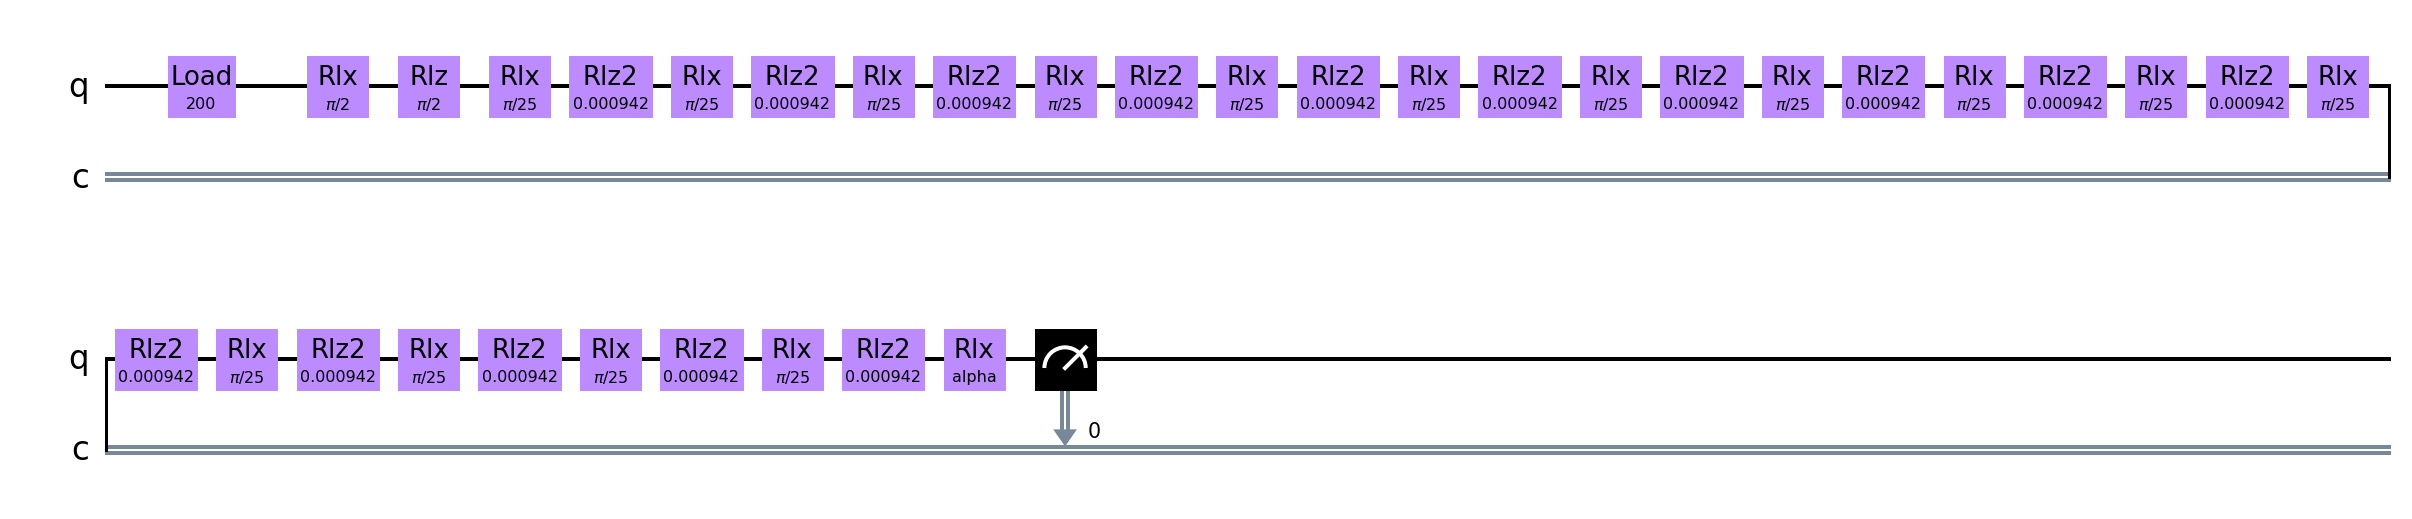

In [8]:
circuit1 = QuantumCircuit(1, 1)
circuit1.load(0,Nat)
circuit1.rLx(0, np.pi/2)
circuit1.rLz(0, np.pi / 2)
for ii in range(Ntrott):
    circuit1.rLx(0,omegax*t1/Ntrott)
    circuit1.rLz2(0,chi*t1/Ntrott)
circuit1.rLx(0,alpha)
circuit1.measure(0, 0)
circuit1.draw(output='mpl')

In [9]:
circuit1_list = [circuit1.bind_parameters({alpha: -a%(2*np.pi)}) for a in alphas]

In [10]:
job1 = spin_device_backend.run(circuit1_list, shots = 500)

In [11]:
job1.job_id()

'20211120_075909-singlequdit-synqs_test-91e18'

### Next job:

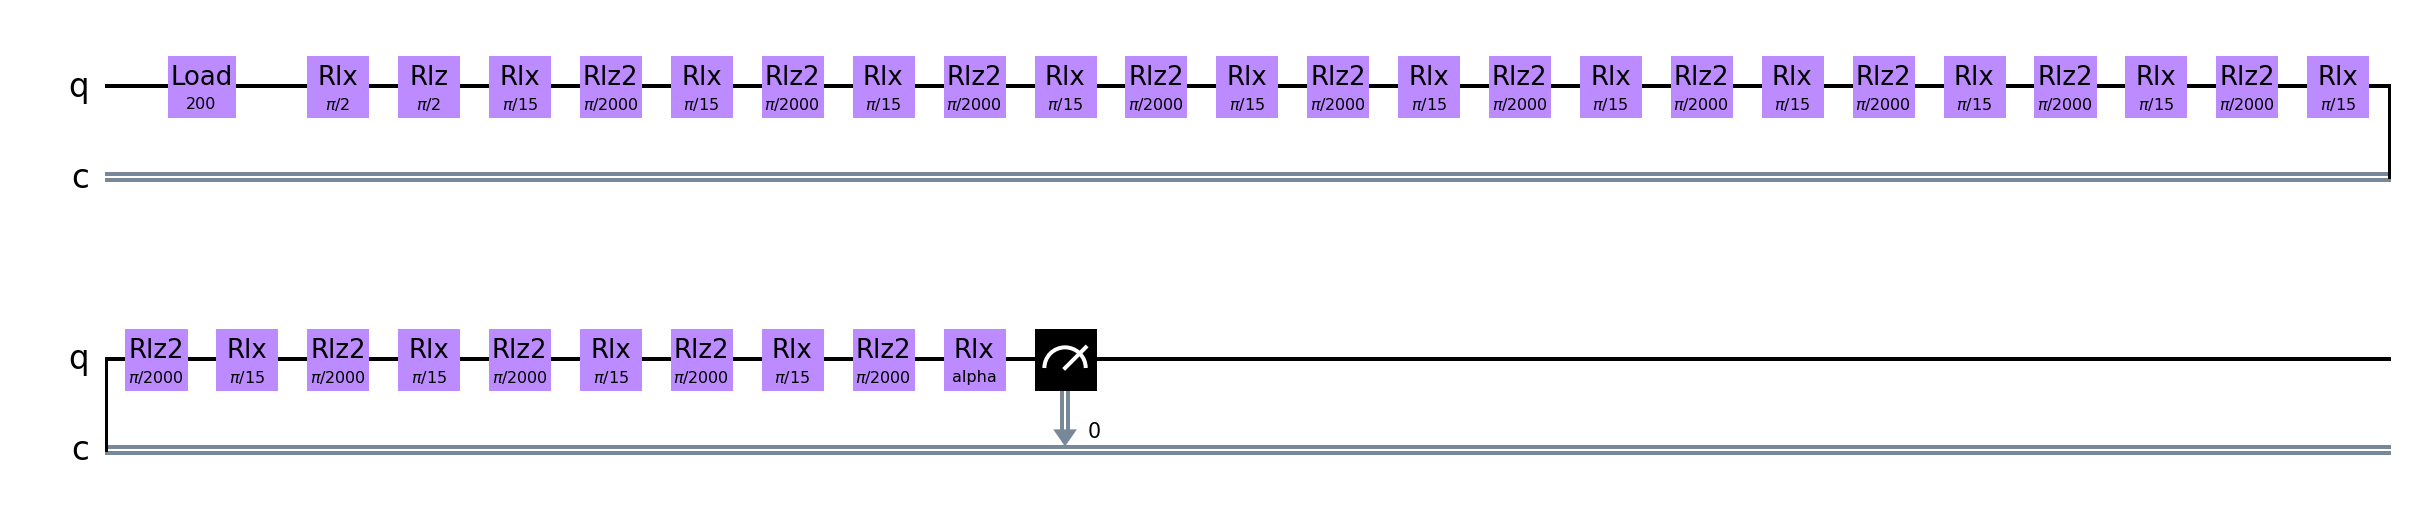

In [12]:
circuit2 = QuantumCircuit(1, 1)
circuit2.load(0,Nat)
circuit2.rLx(0, np.pi/2)
circuit2.rLz(0, np.pi / 2)
for ii in range(Ntrott):
    circuit2.rLx(0,omegax*t2/Ntrott)
    circuit2.rLz2(0,chi*t2/Ntrott)
circuit2.rLx(0,alpha)
circuit2.measure(0, 0)
circuit2.draw(output='mpl')

In [13]:
circuit2_list = [circuit2.bind_parameters({alpha: -a%(2*np.pi)}) for a in alphas]

In [14]:
job2 = spin_device_backend.run(circuit2_list, shots = 500)

In [15]:
job2.job_id()

'20211120_075918-singlequdit-synqs_test-9ec8b'

### Retrieving jobs:

A job that has been run in a previous session can also be retrieved from the backend by providing the `job_id`:

In [16]:
job_retrieved1 = spin_device_backend.retrieve_job(job_id = job1.job_id())

print("job status: ", job_retrieved1.status())

job status:  JobStatus.INITIALIZING


In [17]:
job_retrieved2 = spin_device_backend.retrieve_job(job_id = job2.job_id())

print("job status: ", job_retrieved2.status())

job status:  JobStatus.INITIALIZING


The result of the job can be accessed by directly calling `job.result()` which returns a `Qiskit.Result` object:

In [18]:
result1 = job_retrieved1.result()
#print(type(result1))

In [19]:
result2 = job_retrieved2.result()
#print(type(result2))

In [20]:
outcomes1 = [result1.get_memory(i) for i in range(len(circuit1_list))]
outcomes2 = [result2.get_memory(i) for i in range(len(circuit2_list))]

In [21]:
variances_1 = [np.var(np.array(counts1, dtype=float)) for counts1 in outcomes1]
variances_2 = [np.var(np.array(counts2, dtype=float)) for counts2 in outcomes2]

variances_1 = np.array(variances_1)
variances_2 = np.array(variances_2)

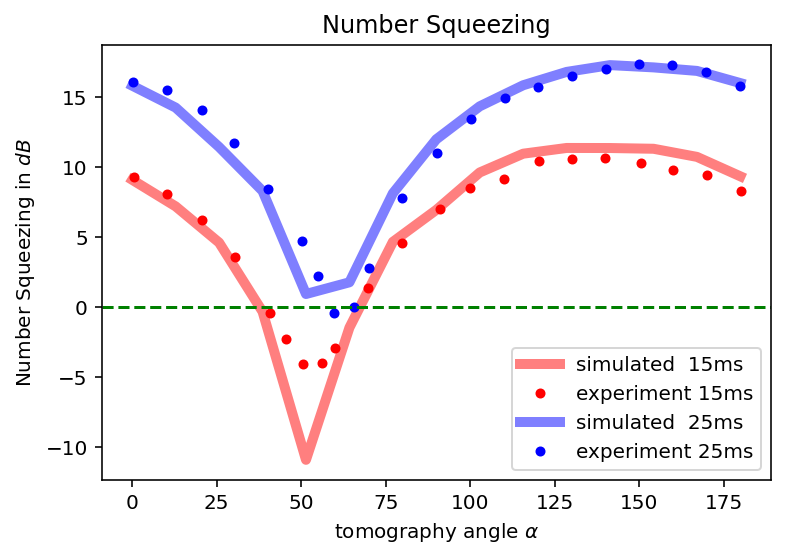

In [22]:
def number_squeezing_factor_to_db(var_CSS, var):
    return 10 * np.log10(var / var_CSS)


f, ax = plt.subplots()
ax.set_title("Number Squeezing")
plt.plot(
    np.rad2deg(alphas),
    number_squeezing_factor_to_db(l / 2, variances_1),
    "r-",
    lw=5,
    label="simulated  15ms",
    alpha=0.5,
)
ax.plot(
    data_strobel_15.dB,
    data_strobel_15.alpha,
    "ro",
    label="experiment 15ms",
    markersize=4,
)
plt.plot(
    np.rad2deg(alphas),
    number_squeezing_factor_to_db(l / 2, variances_2),
    "b-",
    lw=5,
    label="simulated  25ms",
    alpha=0.5,
)
ax.plot(
    data_strobel_25.dB,
    data_strobel_25.alpha,
    "bo",
    label="experiment 25ms",
    markersize=4,
)
ax.axhline(y=0, color="g", linestyle="--")
ax.set_ylabel(r"Number Squeezing in $dB$")
ax.set_xlabel(r"tomography angle $\alpha$")
ax.legend()